<a href="https://colab.research.google.com/github/CatarinaL/ddosLogs/blob/master/tree_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install category_encoders
import numpy as np
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import category_encoders as ce


     |████████████████████████████████| 81kB 6.6MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#data from mounted google drive: /content/drive/MyDrive/datasets/ddosLogs/final-dataset.arff
np.random.seed(123)
file = "/content/drive/MyDrive/datasets/ddosLogs/final-dataset.arff"

data, meta = arff.loadarff(file)
df = pd.DataFrame(data=data)
df.info

<bound method DataFrame.info of          SRC_ADD  DES_ADD  ...  LAST_PKT_RESEVED     PKT_CLASS
0           3.00    24.30  ...         50.021920     b'Normal'
1          15.00    24.15  ...         50.030211     b'Normal'
2          24.15    15.00  ...         50.060221  b'UDP-Flood'
3          24.90     9.00  ...         50.060098     b'Normal'
4          24.80     8.00  ...         50.061864     b'Normal'
...          ...      ...  ...               ...           ...
2160663    24.10    10.00  ...         50.040562     b'Normal'
2160664    24.12    12.00  ...         50.051067     b'Normal'
2160665     1.00    24.10  ...         50.013418     b'Normal'
2160666     5.00    24.50  ...         50.027339     b'Normal'
2160667    15.00    24.15  ...         50.030211     b'Normal'

[2160668 rows x 28 columns]>

In [3]:
df2 = df.copy()

#decode byte strings to remove the "b" before the srting values at cols PKT_CLASS, NODE_NAME_FROM, NODE_NAME_TO, FLAGS, PKT_TYPE 
categoricals = ["NODE_NAME_FROM", "NODE_NAME_TO", "FLAGS", "PKT_TYPE", "PKT_CLASS"]

for categorical in categoricals:
  df2[categorical] = df2[categorical].apply(lambda x: x.decode('utf-8')).astype("category") 


In [4]:
intgs = ["SRC_ADD", "DES_ADD", "PKT_ID", "FROM_NODE", "TO_NODE", "FID"]
for intg in intgs:
  df2[intg] = df2[intg].astype('int64')

In [15]:

X = df2.iloc[:, 0:-1]
y = df2.iloc[:, [-1]]

#split into test and training sets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

from category_encoders.wrapper import PolynomialWrapper
#encode dummy variables for categoricals - use target or boosting for tree based models - https://towardsdatascience.com/getting-deeper-into-categorical-encodings-for-machine-learning-2312acd347c8
enc = PolynomialWrapper(ce.CatBoostEncoder(cols=categoricals[:-1])) #https://maxhalford.github.io/blog/target-encoding/

# transform the datasets
X_train_enc = enc.fit_transform(X_train, y_train)
X_test_enc = enc.transform(X_test)

X_train_enc.info()

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1512467 entries, 303819 to 305711
Data columns (total 39 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   SRC_ADD                    1512467 non-null  int64  
 1   DES_ADD                    1512467 non-null  int64  
 2   PKT_ID                     1512467 non-null  int64  
 3   FROM_NODE                  1512467 non-null  int64  
 4   TO_NODE                    1512467 non-null  int64  
 5   PKT_SIZE                   1512467 non-null  float64
 6   FID                        1512467 non-null  int64  
 7   SEQ_NUMBER                 1512467 non-null  float64
 8   NUMBER_OF_PKT              1512467 non-null  float64
 9   NUMBER_OF_BYTE             1512467 non-null  float64
 10  PKT_IN                     1512467 non-null  float64
 11  PKT_OUT                    1512467 non-null  float64
 12  PKT_R                      1512467 non-null  float64
 13  PKT_DELA

cat boost paper: https://papers.nips.cc/paper/2018/file/14491b756b3a51daac41c24863285549-Paper.pdf

In [51]:
dt = DecisionTreeClassifier(max_depth = 5, random_state = 123)

# Fit dt to the training set
dt.fit(X_train_enc, y_train)


# Predict test set labels
y_pred = dt.predict(X_test_enc)
print(y_pred[0:5])

# Compute test set accuracy  
acc = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}".format(acc))

['Normal' 'Normal' 'Normal' 'UDP-Flood' 'Normal']
Test set accuracy: 0.99


In [52]:
target_classes = list(np.unique(y_test))
feature_names = list(X_train_enc.columns)

target_classes
feature_names

['SRC_ADD',
 'DES_ADD',
 'PKT_ID',
 'FROM_NODE',
 'TO_NODE',
 'PKT_SIZE',
 'FID',
 'SEQ_NUMBER',
 'NUMBER_OF_PKT',
 'NUMBER_OF_BYTE',
 'PKT_IN',
 'PKT_OUT',
 'PKT_R',
 'PKT_DELAY_NODE',
 'PKT_RATE',
 'BYTE_RATE',
 'PKT_AVG_SIZE',
 'UTILIZATION',
 'PKT_DELAY',
 'PKT_SEND_TIME',
 'PKT_RESEVED_TIME',
 'FIRST_PKT_SENT',
 'LAST_PKT_RESEVED',
 'NODE_NAME_FROM_UDP-Flood',
 'NODE_NAME_TO_UDP-Flood',
 'FLAGS_UDP-Flood',
 'PKT_TYPE_UDP-Flood',
 'NODE_NAME_FROM_Smurf',
 'NODE_NAME_TO_Smurf',
 'FLAGS_Smurf',
 'PKT_TYPE_Smurf',
 'NODE_NAME_FROM_HTTP-FLOOD',
 'NODE_NAME_TO_HTTP-FLOOD',
 'FLAGS_HTTP-FLOOD',
 'PKT_TYPE_HTTP-FLOOD',
 'NODE_NAME_FROM_SIDDOS',
 'NODE_NAME_TO_SIDDOS',
 'FLAGS_SIDDOS',
 'PKT_TYPE_SIDDOS']

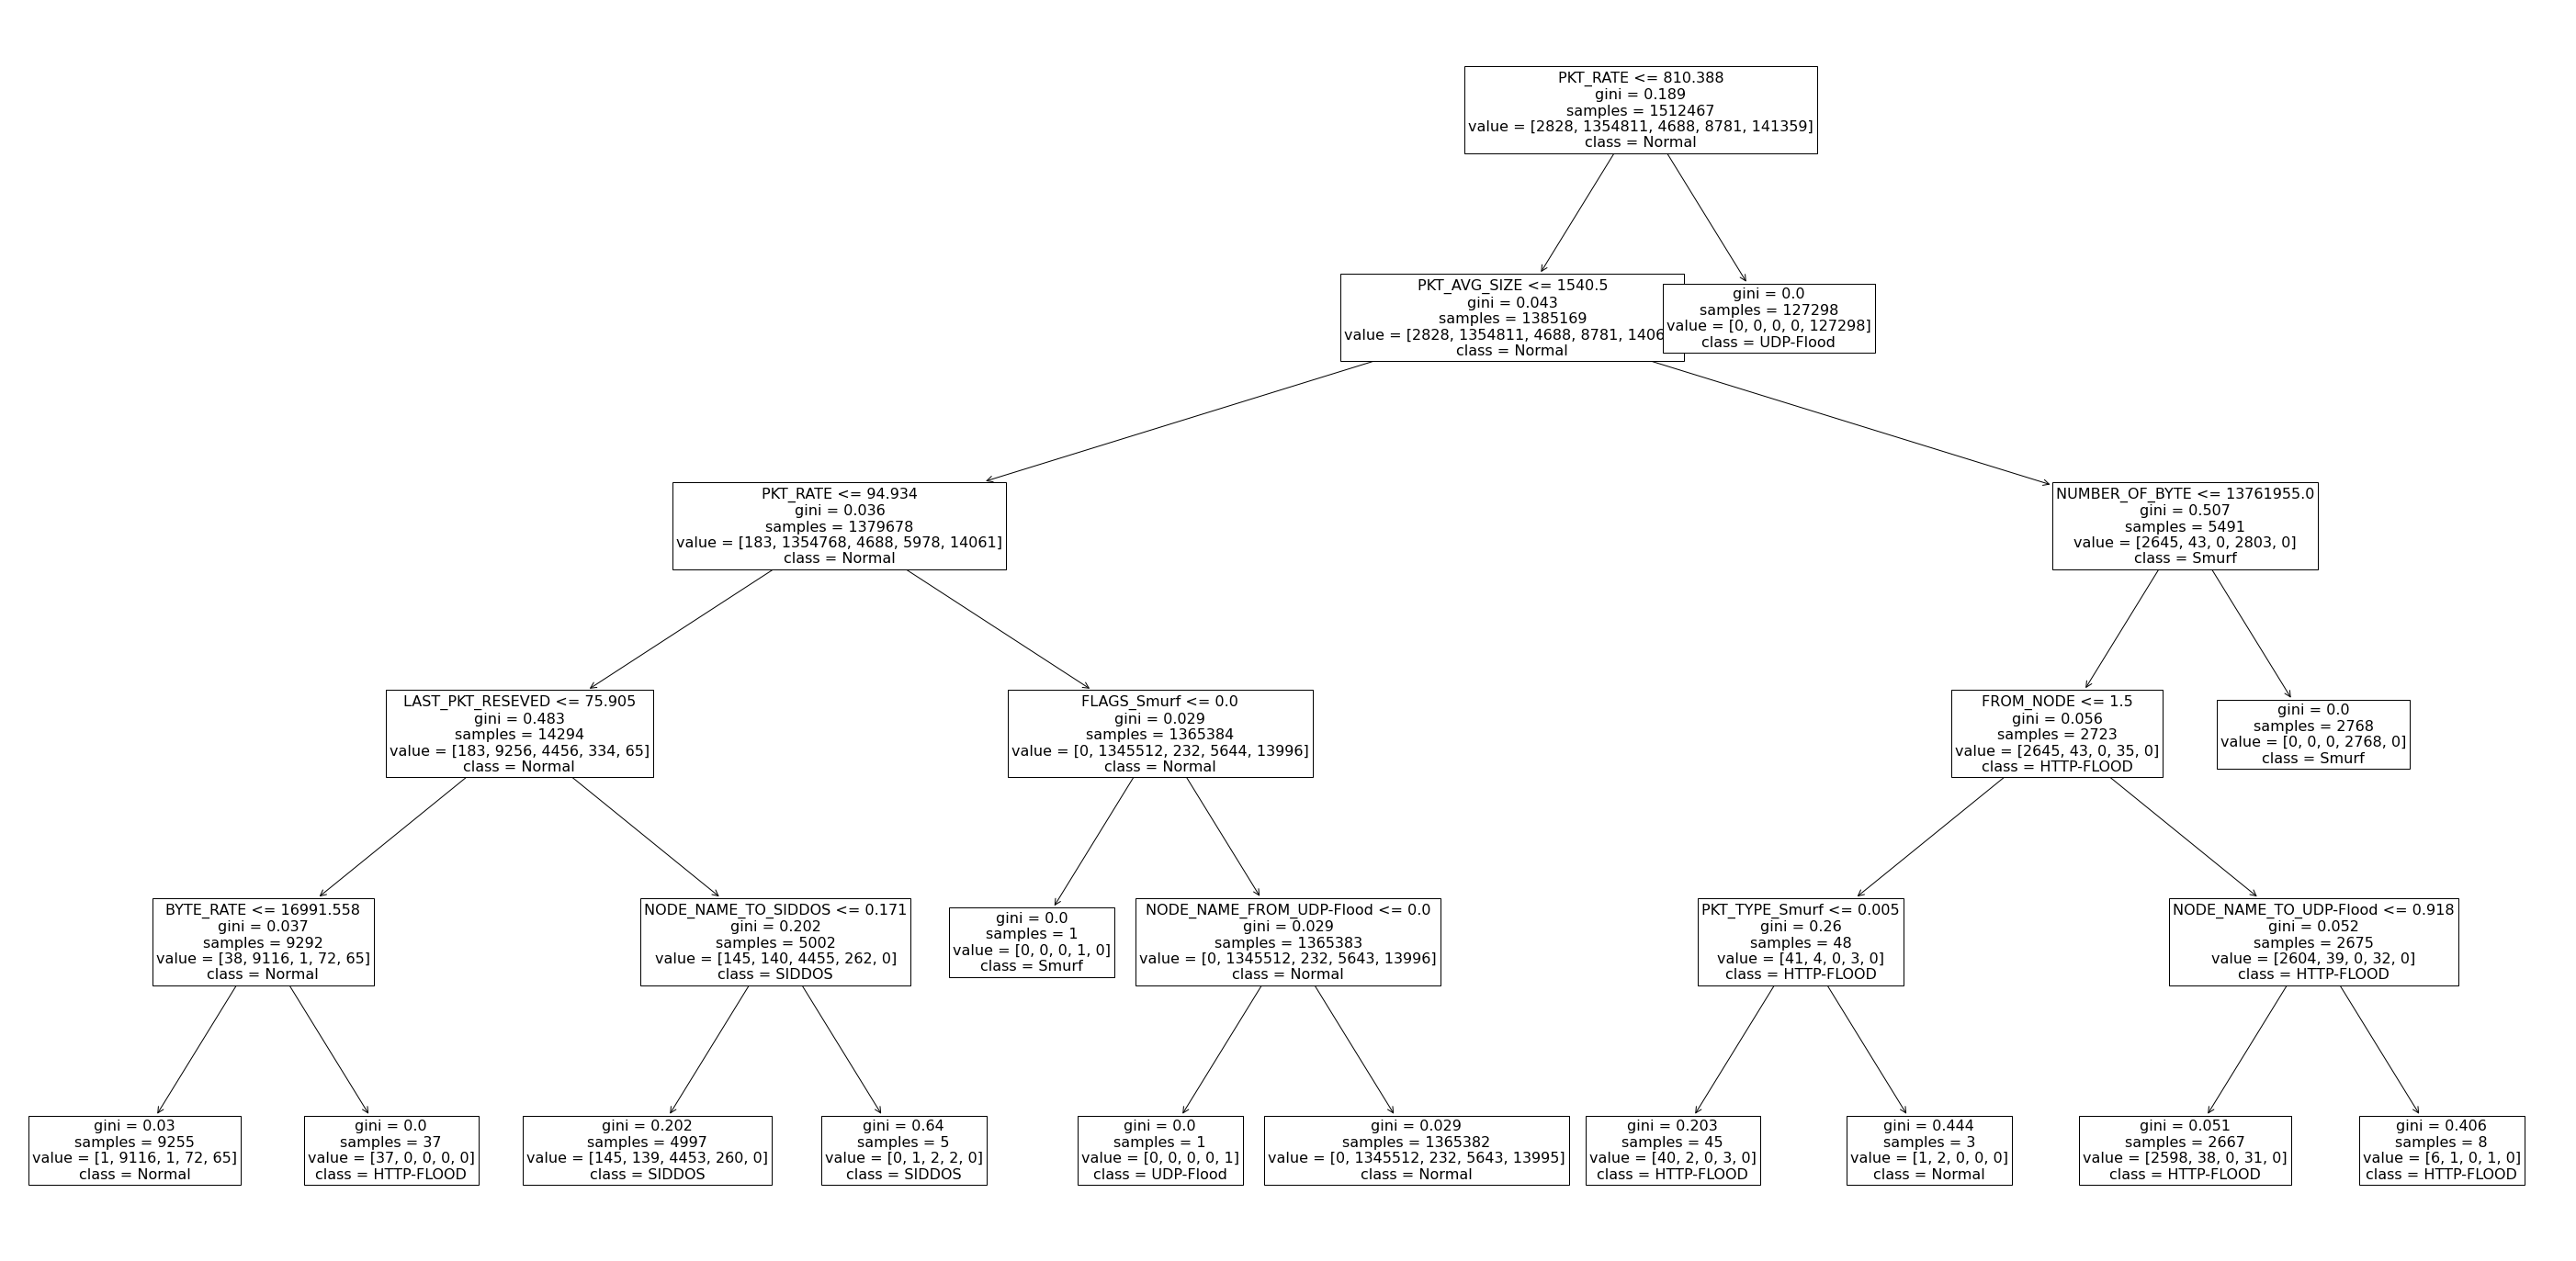

In [53]:

plt.figure(figsize=(50,25))

from sklearn.tree import plot_tree
a = plot_tree(dt, class_names=target_classes, feature_names=feature_names, fontsize=16)

In [ ]:
# Instantiate dt_entropy, set 'entropy' as the information criterion
dt_entropy = DecisionTreeClassifier(max_depth = 8, criterion = 'entropy', random_state = 1)

# Fit dt_entropy to the training set
dt_entropy.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred= dt_entropy.predict(X_test)

# Evaluate accuracy_entropy
accuracy_entropy = accuracy_score(y_pred, y_test)

# Print accuracy_entropy
print('Accuracy achieved by using entropy: ', accuracy_entropy)

# Print accuracy_gini
print('Accuracy achieved by using the gini index: ', accuracy_gini)